# Project - Fully Convolutional Network

###  1.Create data dictionary by train, valid and test

In [1]:
import pandas as pd
import os

In [2]:
# Load metadata splits using your local route
meta_split = pd.read_csv('data/metadata_splits.csv')  # Adjusted path for your project folder

# Extract main data columns
meta_data = meta_split[['id', 'file_name', 'split_open']]

# Get unique data types (train, valid, test)
data_type = set(meta_data['split_open'])

# Create a dictionary to hold data for each type
meta_data_dict = {}
for type in data_type:
    meta_data_dict[type] = []

# Populate the dictionary with IDs and file names based on data type
for index, row in meta_data.iterrows():
    meta_data_dict[row['split_open']].append((row['id'], row['file_name']))

# Print the number of images in each set
print(f"train set number: {len(meta_data_dict['train'])}")
print(f"valid set number: {len(meta_data_dict['valid'])}")
print(f"test set number: {len(meta_data_dict['test'])}")

# Display the main metadata dataframe
meta_data


train set number: 5303
valid set number: 1118
test set number: 2308


,id,file_name,split_open
0,1,images/t001/CAluWEgwPX.JPG,train
1,2,images/t001/EKyrFKHQzh.JPG,train
2,3,images/t001/ELAvEqeXxT.JPG,train
3,4,images/t001/IxRLFwTGCv.JPG,train
4,5,images/t001/LKCJAhfLBJ.JPG,train
...,...,...,...
8724,8725,images/t610/miUGGSioXO.jpeg,test
8725,8726,images/t610/aOzTdMCkzF.jpeg,test
8726,8727,images/t610/ZmTLXySHIZ.jpeg,test
8727,8728,images/t610/qVDYBLbzda.jpeg,test


### 2.Set class dataset by using coco

for getting image and mask, then we can put into model

In [3]:
import json
from pycocotools.coco import COCO
from pprint import pprint
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import Dataset 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.models.segmentation
import torch.optim as optim 
import torch

In [4]:
# set img dir
image_dir = 'data/images'

# json to coco
coco = COCO('data/annotations.json')

# image and mask transform method
transform_method = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

target_transform_method = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST), 
    transforms.Lambda(lambda mask: torch.from_numpy(np.array(mask)).long())
])

loading annotations into memory...
Done (t=3.70s)
creating index...
index created!


In [5]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, coco, meta_data_dict, data_type, transform=None, target_transform=None):
        self.image_dir = image_dir  # original image dir
        self.coco = coco # coco
        self.data_type = data_type # train valid test
        self.transform = transform  # transform method
        self.target_transform = target_transform  # transform method
        self.images = [] # all original images path in train set

        data_list = meta_data_dict[self.data_type]
        img_Ids = self.coco.getImgIds()

        for i in img_Ids:
            # if img_id in data_type list is true
            if any(t[0] == i for t in data_list):
                self.images.append(self.coco.loadImgs(i)[0])

    def process_mask(self, image_id, image):
        category_map = {
            1: 1,  # turtles
            2: 2,  # flipper
            3: 3   # head
        }
        
        mask = np.zeros((image.size[1], image.size[0]), dtype=np.uint8)
        for cat_id, target_value in category_map.items():
            ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=cat_id, iscrowd=None)
            anns = self.coco.loadAnns(ann_ids)
            for ann in anns:
                ann_mask = self.coco.annToMask(ann)
                mask[ann_mask > 0] = target_value  
                
        return mask

    def __len__(self):  # set dataset size
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        # Get image ID
        img_id = img['id']
        # Get image file name
        img_file_name = img['file_name']

        # Construct the full image path
        if img_file_name.startswith('images/'):  # Check if the path already includes 'images'
            image_path = os.path.join(self.image_dir, img_file_name.split('images/', 1)[-1])
        else:
            image_path = os.path.join(self.image_dir, img_file_name)

        # Load the image and convert to RGB
        image = Image.open(image_path).convert("RGB")
        
        # Process the mask
        mask = self.process_mask(img_id, image)
        mask = Image.fromarray(mask.astype('uint8'))  # Convert to PIL image

        # Transform the image and mask to [C, H, W]
        image = self.transform(image)
        mask = self.target_transform(mask)

        return image, mask




    
    # image: PIL [H,W,C] -> [C,H,W]
    # mask: numpy -> PIL [H,W,C] -> [C,H,W]


### 3.Create dataset for train, valid, test

In [6]:
# create train dateset
train_dataset = CustomDataset(
    image_dir=image_dir,
    coco=coco,
    transform=transform_method,
    meta_data_dict=meta_data_dict,
    target_transform=target_transform_method,
    data_type='train'
)

# create valid dataset
valid_dataset = CustomDataset(
    image_dir=image_dir,
    coco=coco,
    transform=transform_method,
    meta_data_dict=meta_data_dict,
    target_transform=target_transform_method,
    data_type='valid'
)

# create test dataset
test_dataset = CustomDataset(
    image_dir=image_dir,
    coco=coco,
    transform=transform_method,
    meta_data_dict=meta_data_dict,
    target_transform=target_transform_method,
    data_type='test'
)

### 4.Create dataloader
divide dataset into samll dataset in order to improving effiency

In [7]:
# create valid DataLoader
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=True)
# create test DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
# create train DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# see the data set size
for images, masks in train_dataloader:
    print("Batch of images:", images.shape)  # show the first image tensor
    print("Batch of masks:", masks.shape)    # show the first mask tensor
    unique_values = torch.unique(masks)     
    print("Masks dtype:", masks.dtype)      # show the first mask dtype
    print("Masks value:", unique_values)    # show the first mask uniqe
    break  # just want to the first one


Batch of images: torch.Size([8, 3, 512, 512])
Batch of masks: torch.Size([8, 512, 512])
Masks dtype: torch.int64
Masks value: tensor([0, 1, 2, 3])


### 5.Show dataloader size and dataset size

In [8]:
print("Total number of images in the dataset:", len(train_dataset))
print("Total number of images in the dataset:", len(valid_dataset))
print("Total number of images in the dataset:", len(test_dataset))

Total number of images in the dataset: 5303
Total number of images in the dataset: 1118
Total number of images in the dataset: 2308


In [9]:
# Check if PyTorch recognizes the GPU
print("Is CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


Is CUDA available: True
Device name: NVIDIA GeForce RTX 4070 Ti


### Half the training data

In [10]:
from torch.utils.data import random_split

train_size = int(0.5 * len(train_dataset))
train_subset, _ = random_split(train_dataset, [train_size, len(train_dataset) - train_size])

train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=8, shuffle=True)


### 6.Using UNet model to get iou and miou

In [11]:
from torchvision import models

num_classes = 4

# FCN model with a ResNet50 backbone
model = models.segmentation.fcn_resnet50(pretrained=False)

# Modify the classifier for the number of classes

model.classifier[4] = torch.nn.Conv2d(512, num_classes, kernel_size=(1, 1))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 25

c:\Users\andyw\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andyw\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
import os
# caculate iou function
def calculate_iou(pred_mask, true_mask, num_classes):
    ious = []
    pred_mask = pred_mask.view(-1)  
    true_mask = true_mask.view(-1)  

    for cls in range(1, num_classes):  # only caculate iou for three classes
        pred_inds = (pred_mask == cls)
        true_inds = (true_mask == cls)
        
        intersection = (pred_inds & true_inds).sum().float()  
        union = (pred_inds | true_inds).sum().float()  

        if union == 0:
            ious.append(float('nan'))  # avoid denominators of zero
        else:
            ious.append((intersection / union).item())  # append iou in list

    return ious # return list

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [ ]:
# Directory to save the model weights
os.makedirs('./fcn_res', exist_ok=True)
save_path = './fcn_res/fcn_model_epoch{}.pth'

# ----------------------
# Training Phase
# ----------------------
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_dataloader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.squeeze(1)

        optimizer.zero_grad()
        outputs = model(images)["out"]
        loss = criterion(outputs, masks.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print training loss
    avg_train_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Save model weights at the end of each epoch
    torch.save(model.state_dict(), save_path.format(epoch + 1))
    print(f"Model weights saved for epoch {epoch + 1} at {save_path.format(epoch + 1)}")

    # ----------------------
    # Validation Phase
    # ----------------------
    model.eval()  # Set model to evaluation mode
    all_ious = []  # Record all IoUs in one epoch

    with torch.no_grad():  # No gradient computation
        for images, masks in valid_dataloader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.squeeze(1)

            outputs = model(images)["out"]
            pred_masks = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                ious = calculate_iou(pred_masks[i], masks[i], num_classes=num_classes)
                all_ious.append(ious)

    # Calculate mIoU and average of total mIoU
    all_ious_tensor = torch.tensor(all_ious)
    mean_ious = torch.nanmean(all_ious_tensor, dim=0)
    avg_all_mious = torch.nanmean(mean_ious).item()

    # Print validation results
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation mIoU: {avg_all_mious:.4f}")
    for cls in range(num_classes):
        if cls == 0:
            print(f" - Class {cls + 1} 'turtle' mIoU: {mean_ious[cls].item():.4f}")
        elif cls == 1:
            print(f" - Class {cls + 1} 'flipper' mIoU: {mean_ious[cls].item():.4f}")
        elif cls == 2:
            print(f" - Class {cls + 1} 'head' mIoU: {mean_ious[cls].item():.4f}")

    print("----------------------------------------------------------------")


Epoch [1/25], Training Loss: 0.1081
Model weights saved for epoch 1 at ./fcn_res/fcn_model_epoch1.pth
Epoch [1/25], Validation mIoU: 0.7591
 - Class 1 'turtle' mIoU: 0.8540
 - Class 2 'flipper' mIoU: 0.7089
 - Class 3 'head' mIoU: 0.7144
----------------------------------------------------------------
Epoch [2/25], Training Loss: 0.0352
Model weights saved for epoch 2 at ./fcn_res/fcn_model_epoch2.pth
Epoch [2/25], Validation mIoU: 0.7911
 - Class 1 'turtle' mIoU: 0.8696
 - Class 2 'flipper' mIoU: 0.7502
 - Class 3 'head' mIoU: 0.7536
----------------------------------------------------------------
Epoch [3/25], Training Loss: 0.0261
Model weights saved for epoch 3 at ./fcn_res/fcn_model_epoch3.pth
Epoch [3/25], Validation mIoU: 0.8149
 - Class 1 'turtle' mIoU: 0.8859
 - Class 2 'flipper' mIoU: 0.7788
 - Class 3 'head' mIoU: 0.7800
----------------------------------------------------------------
Epoch [4/25], Training Loss: 0.0218
Model weights saved for epoch 4 at ./fcn_res/fcn_model_

TypeError: argmax(): argument 'input' (position 1) must be Tensor, not collections.OrderedDict

### Ignore the TypeError Above, Testing is Moved below.

In [15]:

# ----------------------
# Testing Phase
# ----------------------
model.eval()
test_ious = []

with torch.no_grad():
    for images, masks in test_dataloader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.squeeze(1)

        outputs = model(images)["out"]
        pred_masks = torch.argmax(outputs, dim=1)

        for i in range(images.size(0)):
            ious = calculate_iou(pred_masks[i], masks[i], num_classes=num_classes)
            test_ious.append(ious)

# Calculate mIoU and average of total mIoU for testing
all_ious_tensor = torch.tensor(test_ious)
mean_ious = torch.nanmean(all_ious_tensor, dim=0)
avg_all_mious = torch.nanmean(mean_ious).item()

# Print test results
print(f"Testing the average of three class mIoU: {avg_all_mious:.4f}")
for cls in range(num_classes):
    if cls == 0:
        print(f" - Class {cls + 1} 'turtle' mIoU: {mean_ious[cls].item():.4f}")
    elif cls == 1:
        print(f" - Class {cls + 1} 'flipper' mIoU: {mean_ious[cls].item():.4f}")
    elif cls == 2:
        print(f" - Class {cls + 1} 'head' mIoU: {mean_ious[cls].item():.4f}")



Testing the average of three class mIoU: 0.8543
 - Class 1 'turtle' mIoU: 0.9233
 - Class 2 'flipper' mIoU: 0.8379
 - Class 3 'head' mIoU: 0.8017


## Ensemble Using weighted voting
This section includes our ensemble model for testing set usign 30% weight for FCN, U-Net, Deeplabv3 for their high performance and 10% for Deeplabv3+

In [13]:
fcn_weights_path = './models/fcn_model.pth'           # state_dict
unet_weights_path = './models/unet_model.pth'         # state_dict
deeplabv3_weights_path = './models/deeplabv3_model.pth'  # full model
deeplabv3p_weights_path = './models/deeplabv3_plus_model.pth' # full model

In [14]:
# Import necessary libraries
import torch
from torchvision import models
from segmentation_models_pytorch import Unet, DeepLabV3Plus

# Number of classes
num_classes = 4  # Background, turtle, flipper, head

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------------------------
# Load FCN Model (state_dict)
# --------------------------
fcn_model = models.segmentation.fcn_resnet50(pretrained=False)
fcn_model.classifier[4] = torch.nn.Conv2d(512, num_classes, kernel_size=(1, 1))
fcn_model.load_state_dict(torch.load(fcn_weights_path))
fcn_model = fcn_model.to(device)
fcn_model.eval()

# --------------------------
# Load UNet Model (state_dict)
# --------------------------
unet_model = Unet('resnet34', classes=num_classes, activation=None)
unet_model.load_state_dict(torch.load(unet_weights_path))
unet_model = unet_model.to(device)
unet_model.eval()

# --------------------------
# Load DeepLabV3 Model (full model)
# --------------------------
deeplabv3_model = torch.load(deeplabv3_weights_path)  # Directly load full model
deeplabv3_model = deeplabv3_model.to(device)
deeplabv3_model.eval()

# --------------------------
# Load DeepLabV3+ Model (full model)
# --------------------------
deeplabv3p_model = torch.load(deeplabv3p_weights_path)  # Directly load full model
deeplabv3p_model = deeplabv3p_model.to(device)
deeplabv3p_model.eval()



c:\Users\andyw\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andyw\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\andyw\AppData\Local\Temp\ipykernel_13904\1793462439.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipp

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

### Use the stored base models, obtain the predictions of the testing set for each model first

In [15]:
# Generate predictions
test_preds_fcn, test_preds_unet, test_preds_deeplabv3, test_preds_deeplabv3p = [], [], [], []

with torch.no_grad():
    for images, _ in test_dataloader:  # No need for ground truth masks here
        images = images.to(device)

        # FCN predictions
        outputs_fcn = fcn_model(images)['out']
        test_preds_fcn.append(torch.argmax(outputs_fcn, dim=1).cpu())

        # UNet predictions
        outputs_unet = unet_model(images)
        test_preds_unet.append(torch.argmax(outputs_unet, dim=1).cpu())

        # DeepLabV3 predictions
        outputs_deeplabv3 = deeplabv3_model(images)['out']
        test_preds_deeplabv3.append(torch.argmax(outputs_deeplabv3, dim=1).cpu())

        # DeepLabV3+ predictions
        outputs_deeplabv3p = deeplabv3p_model(images)
        test_preds_deeplabv3p.append(torch.argmax(outputs_deeplabv3p, dim=1).cpu())

# Concatenate all predictions
test_preds_fcn = torch.cat(test_preds_fcn, dim=0)
test_preds_unet = torch.cat(test_preds_unet, dim=0)
test_preds_deeplabv3 = torch.cat(test_preds_deeplabv3, dim=0)
test_preds_deeplabv3p = torch.cat(test_preds_deeplabv3p, dim=0)


In [ ]:
# Create the directory if it doesn't exist
os.makedirs('./predictions', exist_ok=True)

# Save predictions to disk just in case kernel crashes
torch.save(test_preds_fcn, './predictions/test_preds_fcn.pt')
torch.save(test_preds_unet, './predictions/test_preds_unet.pt')
torch.save(test_preds_deeplabv3, './predictions/test_preds_deeplabv3.pt')
torch.save(test_preds_deeplabv3p, './predictions/test_preds_deeplabv3p.pt')

### Get ensemble predictions useing weighted voting and the 4 models prediction

In [ ]:
# Define weights for the models
weight_fcn = 0.3
weight_unet = 0.3
weight_deeplabv3 = 0.3
weight_deeplabv3p = 0.1

# Initialize variables for storing results
num_classes = 4
# Store final predictions
ensemble_preds = []

# Process predictions batch-wise
# Adjust batch size based on available memory
batch_size = 16

for start_idx in range(0, test_preds_fcn.size(0), batch_size):
    end_idx = min(start_idx + batch_size, test_preds_fcn.size(0))

    # Slice predictions for the current batch
    batch_fcn = test_preds_fcn[start_idx:end_idx]
    batch_unet = test_preds_unet[start_idx:end_idx]
    batch_deeplabv3 = test_preds_deeplabv3[start_idx:end_idx]
    batch_deeplabv3p = test_preds_deeplabv3p[start_idx:end_idx]

    # Convert batch predictions to one-hot encoded probabilities
    fcn_one_hot = torch.nn.functional.one_hot(batch_fcn, num_classes=num_classes).permute(0, 3, 1, 2).float()
    unet_one_hot = torch.nn.functional.one_hot(batch_unet, num_classes=num_classes).permute(0, 3, 1, 2).float()
    deeplabv3_one_hot = torch.nn.functional.one_hot(batch_deeplabv3, num_classes=num_classes).permute(0, 3, 1, 2).float()
    deeplabv3p_one_hot = torch.nn.functional.one_hot(batch_deeplabv3p, num_classes=num_classes).permute(0, 3, 1, 2).float()

    # Aggregate weighted probabilities for the current batch
    weighted_probs = (
        weight_fcn * fcn_one_hot
        + weight_unet * unet_one_hot
        + weight_deeplabv3 * deeplabv3_one_hot
        + weight_deeplabv3p * deeplabv3p_one_hot
    )

    # Get final predictions for the current batch
    batch_preds = torch.argmax(weighted_probs, dim=1)
    ensemble_preds.append(batch_preds)

# Concatenate predictions for all batches
ensemble_preds = torch.cat(ensemble_preds, dim=0)


In [19]:
# Extract ground truth masks from the test dataloader
test_masks = []

with torch.no_grad():
    for _, masks in test_dataloader:
        test_masks.append(masks)

# Concatenate all masks into a single tensor
test_masks = torch.cat(test_masks, dim=0)  # Shape: [N, H, W]


### Calculate ensemble model IoU and MIoU

In [25]:
# IoU and mIoU calculation
test_ious = []

# Evaluate IoU for each prediction
for i in range(ensemble_preds.size(0)):
    ious = calculate_iou(ensemble_preds[i], test_masks[i], num_classes=num_classes)
    test_ious.append(ious)

# Convert IoU list to a tensor for further analysis
all_ious_tensor = torch.tensor(test_ious)  # Shape: [N, num_classes]

# Calculate mean IoU per class
mean_ious = torch.nanmean(all_ious_tensor, dim=0)  # [num_classes]

# Calculate overall mean IoU (mIoU)
avg_all_mious = torch.nanmean(mean_ious).item()

# Print results
# Print IoU for each class (ignore background)
print(f"Ensemble Testing Results:")
print(f" - Overall mIoU (excluding background): {avg_all_mious:.4f}")
print(f" - Class 1 (Turtle): mIoU: {mean_ious[0].item():.4f}")
print(f" - Class 2 (Flipper): mIoU: {mean_ious[1].item():.4f}")
print(f" - Class 3 (Head): mIoU: {mean_ious[2].item():.4f}")



Ensemble Testing Results:
 - Overall mIoU (excluding background): 0.8709
 - Class 1 (Turtle): mIoU: 0.9328
 - Class 2 (Flipper): mIoU: 0.8580
 - Class 3 (Head): mIoU: 0.8218


### Get a sample plot to visualise in report and video

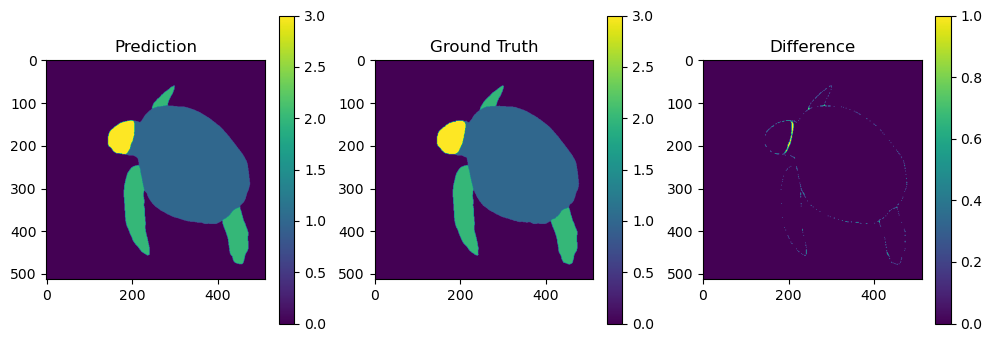

In [26]:
import matplotlib.pyplot as plt

# Visualize predictions and ground truth for a random sample
idx = 0  # Change to visualize different samples
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.title("Prediction")
plt.imshow(ensemble_preds[idx].cpu(), cmap="viridis")
plt.colorbar()

# Ground truth mask
plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(test_masks[idx].cpu(), cmap="viridis")
plt.colorbar()

# Difference (for debugging)
plt.subplot(1, 3, 3)
plt.title("Difference")
plt.imshow((ensemble_preds[idx] != test_masks[idx]).cpu(), cmap="viridis")
plt.colorbar()

plt.show()
